## Home Credit Default Risk
Data exploration of home credit risk. I will explore buidling models at a later stage.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from sklearn.metrics import roc_auc_score
xgb.__version__
from imblearn.over_sampling import SMOTE

### Nice way to impute missing values
https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn#25562948

In [2]:
from sklearn.base import TransformerMixin
class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

### Join df
join_df is a function for joining tables on specific fields. By default, we'll be doing a left outer join of right on the left argument using the given fields for each table.
Pandas does joins using the merge method. The suffixes argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "_y" to those on the right.

In [3]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

### Load train data

In [4]:
application_train = pd.read_csv('application_train.csv.zip', compression='infer')
application_train=DataFrameImputer().fit_transform(application_train)
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Get the predicted column out of train set

In [5]:
#y=pd.Categorical(application_train['TARGET'])
targets=application_train['TARGET']
application_train.drop(['TARGET'],inplace=True, axis=1)
print(application_train.shape)

(307511, 121)


### Load test data

In [6]:
# Use the forest's predict method on the test data
application_test = pd.read_csv('application_test.csv.zip', compression='infer')
#application_test.fillna(method='ffill', inplace=True)
#application_test.fillna(method='bfill', inplace=True)
application_test=DataFrameImputer().fit_transform(application_test)
print(application_test.shape)
application_test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


### Derieved features

In [9]:
application_test['LOAN_INCOME_RATIO']=application_test.AMT_CREDIT/application_test.AMT_INCOME_TOTAL
application_test['ANNUITY_INCOME_RATIO']=application_test.AMT_ANNUITY/application_test.AMT_INCOME_TOTAL
application_train['LOAN_INCOME_RATIO']=application_train.AMT_CREDIT/application_train.AMT_INCOME_TOTAL
application_train['ANNUITY_INCOME_RATIO']=application_train.AMT_ANNUITY/application_train.AMT_INCOME_TOTAL

### Combine train and test, preprocess then separate

In [10]:
application = pd.concat(objs=[application_train, application_test], axis=0)

### Take a look at missing values
No graph plotted means none

In [11]:
#sns.set(rc={'figure.figsize':(12,6)})
percentage_nan=application.isnull().sum()/application.shape[0]
percentage_nan.sort_values(inplace=True)
if percentage_nan[0]>0.0:
    percentage_nan[percentage_nan>0.0].plot('bar',title='Features with missing values')

#### Identify continous and categorical columns

In [12]:
cat_cols=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_EDUCATION_TYPE','NAME_CONTRACT_TYPE',\
         'NAME_TYPE_SUITE','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_CONT_MOBILE','OCCUPATION_TYPE',\
         'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY',\
         'REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','ORGANIZATION_TYPE','WEEKDAY_APPR_PROCESS_START','EMERGENCYSTATE_MODE',\
         'NAME_FAMILY_STATUS','FLAG_EMAIL','NAME_HOUSING_TYPE','NAME_INCOME_TYPE','WALLSMATERIAL_MODE','FONDKAPREMONT_MODE','HOUSETYPE_MODE']

for colname in list(application.filter(regex=("FLAG_DOCUMENT_.*"))):
    cat_cols.append(colname)
for colname in cat_cols:
    application[colname]=application[colname].astype('category')

#get the continous columns
conti_cols=set(application.columns)-set(cat_cols)
conti_cols.remove('SK_ID_CURR')
cat_cols=list(set(cat_cols))

### Scalarize continuous variables

In [13]:
for col in conti_cols:
    std=application[col].std()
    mean=application[col].mean()
    application[col]=(application[col]-mean)/std

In [14]:
application.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 48743
Columns: 123 entries, SK_ID_CURR to ANNUITY_INCOME_RATIO
dtypes: category(48), float64(74), int64(1)
memory usage: 222.9 MB


### Exploration train data

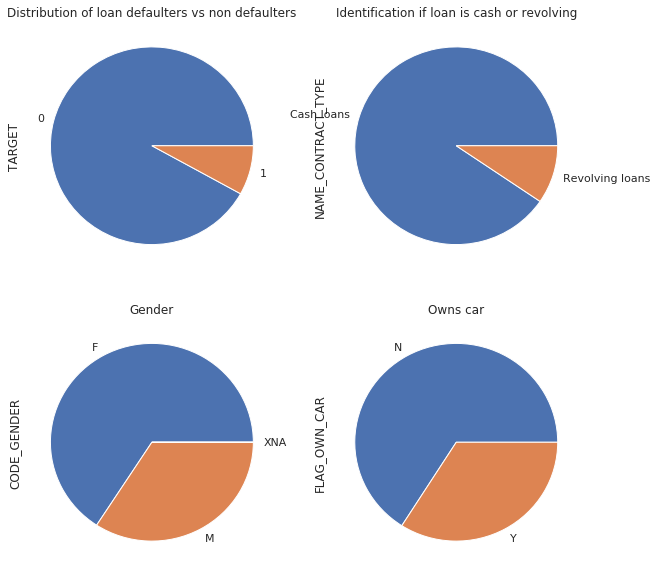

In [15]:
#sns.set(rc={'figure.figsize':(11,8)})
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)
#this is an unbalanced data set
application_train['TARGET']=targets
application_train.TARGET.astype('category').value_counts().plot(kind='pie',title='Distribution of loan defaulters vs non defaulters',ax=axes[0,0])
application_train.NAME_CONTRACT_TYPE.astype('category').value_counts().plot(kind='pie',title='Identification if loan is cash or revolving',ax=axes[0,1])
application_train.CODE_GENDER.astype('category').value_counts().plot(kind='pie',title='Gender',ax=axes[1,0])
application_train.FLAG_OWN_CAR.astype('category').value_counts().plot(kind='pie',title='Owns car',ax=axes[1,1])

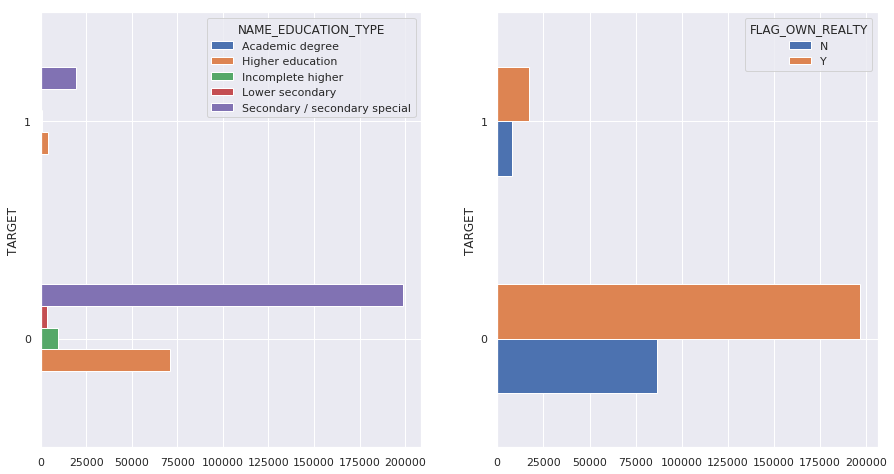

In [16]:
#sns.set(rc={'figure.figsize':(11,8)})
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 8)
application_train.groupby('NAME_EDUCATION_TYPE').TARGET.value_counts().unstack(0).plot.barh(ax=axes[0])
application_train.groupby('FLAG_OWN_REALTY').TARGET.value_counts().unstack(0).plot.barh(ax=axes[1])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


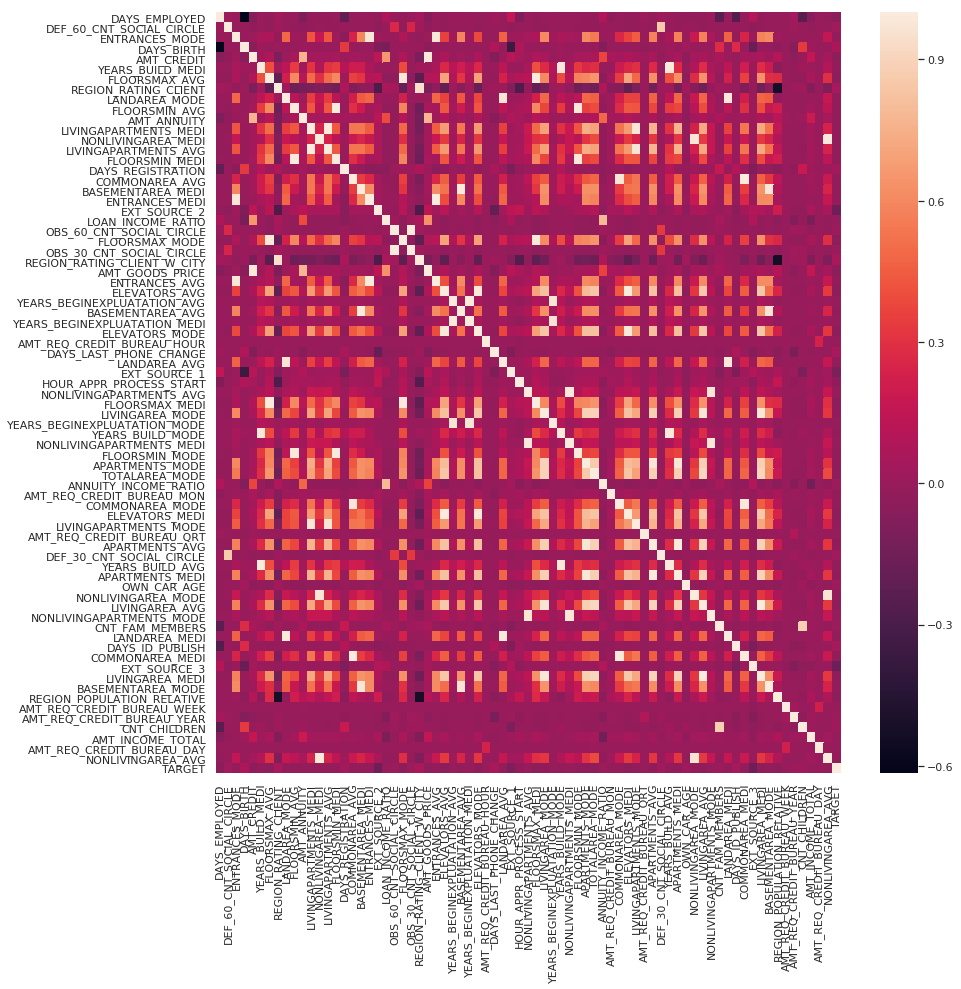

In [17]:
# Normalized score from external data source suck
sns.set(rc={'figure.figsize':(14,14)})
df=application_train[list(conti_cols)]
df['TARGET']=targets
corr = df.corr()

sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns)



#### One hot encoding/FeatureHasher

In [18]:
application.reset_index(drop=True,inplace=True)
cat_cols=sorted(cat_cols)

In [19]:
from sklearn.feature_extraction import FeatureHasher
for col in cat_cols:
    unique_vals=len(application[col].unique())
    n_features=min(50, (unique_vals+1)//2)
    gen_dummy_features=None
    colnames=[]
    if unique_vals>3:
        fh = FeatureHasher(n_features=n_features, input_type='string')
        hashed_features = fh.fit_transform(application[col])
        hashed_features = hashed_features.toarray()
        for i in range(0,n_features):
            colnames.append(col+'_'+str(i))
        gen_dummy_features=pd.DataFrame(hashed_features,columns=colnames)
    else:
        gen_dummy_features = pd.get_dummies(application[col])
        for val in list(application[col].unique()):
            colnames.append(col+'_'+str(val))
        gen_dummy_features.columns=colnames

    application.drop([col],inplace=True, axis=1)
    application=pd.concat([application, gen_dummy_features],axis=1)



### Store the final dataframe

In [20]:
application.to_pickle('application')

In [21]:
application=pd.read_pickle('application')
application.head()


,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,REG_REGION_NOT_WORK_REGION_0,REG_REGION_NOT_WORK_REGION_1,WALLSMATERIAL_MODE_0,WALLSMATERIAL_MODE_1,WALLSMATERIAL_MODE_2,WALLSMATERIAL_MODE_3,WEEKDAY_APPR_PROCESS_START_0,WEEKDAY_APPR_PROCESS_START_1,WEEKDAY_APPR_PROCESS_START_2,WEEKDAY_APPR_PROCESS_START_3
0,100002,-0.575136,0.144890,-0.454489,-0.184963,-0.483589,-0.152068,1.509646,-0.458375,0.37868,...,1,0,-1.0,-2.0,0.0,-1.0,-2.0,0.0,3.0,0.0
1,100003,-0.575136,0.446894,1.770429,0.561571,1.643875,-1.248728,-0.166044,-0.462263,1.07673,...,1,0,1.0,-1.0,-1.0,0.0,0.0,0.0,4.0,-2.0
2,100004,-0.575136,-0.459118,-1.135827,-1.403427,-1.073868,-0.782252,-0.689352,-0.455467,0.20516,...,1,0,0.0,-1.0,1.0,1.0,0.0,0.0,4.0,-2.0
3,100006,-0.575136,-0.157114,-0.690087,0.153482,-0.631159,-0.926917,-0.679946,-0.475325,-1.37495,...,1,0,0.0,-1.0,1.0,1.0,-2.0,0.0,3.0,0.0
4,100007,-0.575136,-0.217515,-0.187564,-0.377401,-0.040880,0.556664,-0.892619,-0.475318,0.19070,...,1,0,0.0,-1.0,1.0,1.0,-1.0,1.0,1.0,-1.0


### Get back the train and test data

In [22]:
application_train = application.iloc[0:application_train.shape[0],]
application_test = application.iloc[application_train.shape[0]:,]
print(application_train.shape,application_test.shape)
application_train['TARGET']=targets

(307511, 218) (48744, 218)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


#### Create validation, train and test sets

In [23]:
train, valid = train_test_split(application_train, test_size=0.1)
print(train.shape,valid.shape)

train_features=train.loc[:, (train.columns != 'SK_ID_CURR') & (train.columns != 'TARGET')]
features_arr=np.array(train_features)
train_cols=train_features.columns
y=np.array(train.TARGET.astype('category'))

#validation features
valid_features=valid.loc[:, (valid.columns != 'SK_ID_CURR') & (valid.columns != 'TARGET')]
valid_features=np.array(valid_features)

#test features
test_features=application_test.loc[:, (application_test.columns != 'SK_ID_CURR') & (application_test.columns != 'TARGET')]
test_features=np.array(test_features)

(261384, 219) (46127, 219)


#### SMOTE Random over sampling

In [ ]:
sm = SMOTE(random_state=42, sampling_strategy='float',ratio=0.5,n_jobs=4)
x_res, y_res = sm.fit_sample(features_arr, y)

In [ ]:
print(np.bincount(y))
print(np.bincount(y_res))
print(x_res.shape)
print(features_arr.shape)

#### Predict for validation set for the model

In [24]:
from sklearn import metrics
def compute_validation_acc(model):
    predict_proba=model.predict_proba(valid_features)
    pd.Series(predict_proba[:,1]).plot('hist')
    target=np.array(valid['TARGET'].astype('float64'))
    pred=np.array(predict_proba[:,1])
    print("number of positive ssamples:",len(target[target<0.5]))
    print("number of negative ssamples:",len(target[target>=0.5]))
    auc =  roc_auc_score(target,pred)
    print(auc)
    return auc




#### Predict for test set and create file for submission

In [25]:
def model_submission(model,fileName):
    predict_proba=model.predict_proba(test_features)
    ids=application_test.SK_ID_CURR.reset_index(drop=True)
    submission=pd.DataFrame({'SK_ID_CURR':ids,'TARGET':pd.Series(predict_proba[:,1])})
    submission.to_csv(fileName,index=False)
    

### XgBoost Model

In [26]:
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=1000, learning_rate=0.05,tree_method='gpu_hist',\
                        eval_metric='auc').fit(features_arr, y)

number of positive ssamples: 42324
number of negative ssamples: 3803
0.7511845872603474


0.7511845872603474

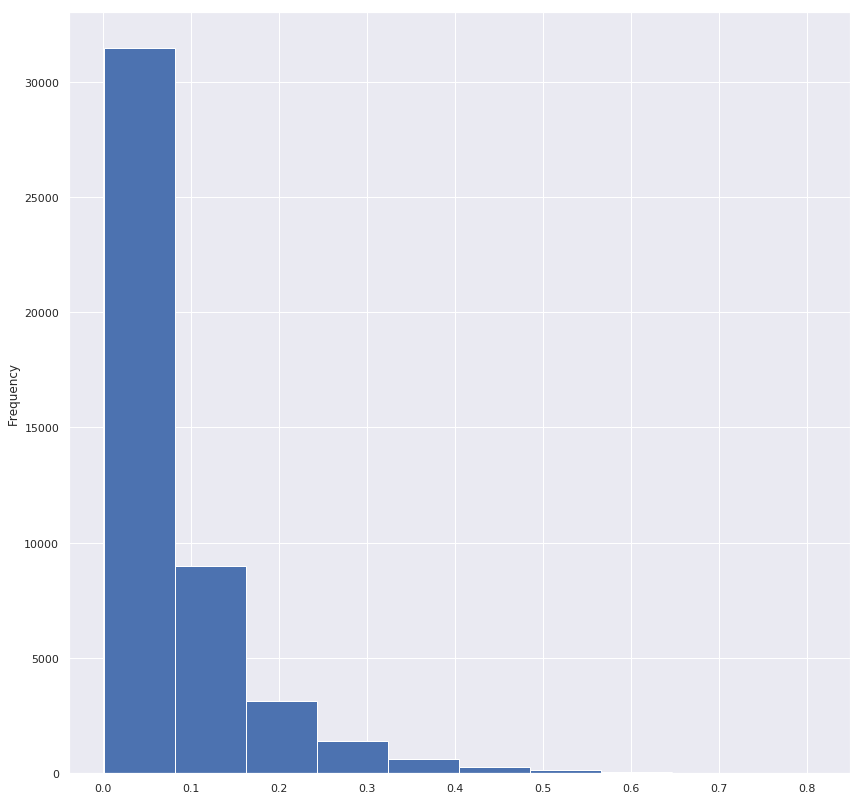

In [27]:
compute_validation_acc(gbm)

In [29]:
model_submission(gbm,"submission_gpoo.csv")

In [ ]:
?roc_auc_score